In [1]:
import cv2 #import computer vision lib
import numpy as np #import numpy as np
import torch #import pytorch
import os #importing operating system , this module provides a way to interact with operating system including accesssing env var and changing the working directory
HOME = os.getcwd() #get the current work directory using the getcwd(), and assign it to home var
print("HOME:", HOME)
%cd {HOME}#this line changes the current working directory to the value of the HOME


HOME: /content
[Errno 2] No such file or directory: '/content#this line changes the current working directory to the value of the HOME'
/content


-Checking if the code is running in python

-Installing packages using pip

-Installing segment-anything model

-Downloading a pre-trained model file called sam_vit_h_4b8939.pth from a Facebook AI Research (FAIR) website.

In [2]:
using_colab = True
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib onnx onnxruntime
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 104.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.9 MB/s eta 0:00:00
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-_edrs1si
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-_edrs1si
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=a44d7de8125aabe6ecebb1fd7e1837bf8cc9489c96b3facb39b4cfdcb83769d3
  Stored in directory: /t

In [3]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.onnx import SamOnnxModel

import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

*show_mask func:*

->it takes a mask and a axis object as input and displays the mask as an image on the axis object

->mask argument is a numpy array that represent a binary mask , it has a shape of (H,W)

->ax argument is an instance of the
matplotlib.axes.Axes class, which is used to create a plot. The imshow function is called on the ax object to display the mask as an image.

->color is a numpy array that represents the color to use when displaying the mask , it has a shape of (4,) and contain red, green, blue , alpha value in order , the value are normalized between 0 and 1

->The mask_image variable is a numpy array that represents the mask as an image.the values in the array are the color values of the mask, multiplied by the color values of the color variable.

->

In [31]:
def show_mask(mask, ax):#it takes a mask and a axis object as input and displays the mask as an image on the axis object
    color = np.array([30/255, 144/255, 255/255, 0.6]) #
    h, w = mask.shape[-2:] #mask argument is a numpy array that represent a binary mask , it has a shape of (H,W) , this code extracts the height and width of the mask image , [-2:] index notation is used to extract the last 2 element in the tuplw which represent the height adn width
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)#this creates a new numpy array called mask_image that has the same height and width as the original mask image, but with a third dimension of size 1.The * operator is used to multiply the mask image and the color array element-wise, resulting in a new array where each pixel is colored according to the color array.this code snippet is used to color a binary mask image with a specific color. The resulting mask_image array can be used as an overlay on top of an image to highlight certain regions or objects.
    ax.imshow(mask_image) #the imshow function is called on the ax object to display the mask_image as an image.

def show_points(coords, labels, ax, marker_size=375):#show_points takes in 3 arguments coords , labels , ax . where coords
    #extracting the coordinates of the positive and negative based on their labels and uses the scatter method of the ax object to plot them on the axis
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25) #marker='*' indicate that the point should be represented by star
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):#this function takes in a bounding box and axis object as input and display the box on the axis obj
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=1))

In [5]:
checkpoint = "/content/sam_vit_h_4b8939.pth"# checkpoint is a string that contains a pre-trained model , its a ViT-H model , which is a type of a iamge classification model that was introduced by google
model_type = "vit_h"

In [6]:
#creating an instance of a SAM model , sam_model_registry is a dict that maps the name of sam model to their classes, model_type is used as a key to look up the corresponding class  , checkpoint var is apssed as an argument to the constructor as a argument to the constructor of the class.
sam = sam_model_registry[model_type](checkpoint=checkpoint)
#predictor object is an instance of the SamPredictor class , which is used to mke predictions using the sam model .
predictor = SamPredictor(sam)

In [7]:
onnx_model_path = None

In [8]:
import warnings

onnx_model_path = "sam_onnx_example.onnx"#this contain the path to the output ONNX model file  , this file will be created by the onn_molde object when it is savec

onnx_model = SamOnnxModel(sam, return_single_mask=True)#onnx_modle var is an instance of SamOnnxModel class , which is used to convert the sam model to the ONNX format  , it takes sam model as an argument and the return_single_mask=True argument is used to indicate that the ONNX model should return a single mask for each image input

#Dynamic axes dict is used to specifly the dynamic axes of a model input and output tensor
#Dynamic axes are the axes that can have a variable length depending on the input data
#point_coords and point_labels tensors have dtnamic axis called num__points, which means their lenght will be determined at runtime based on the number of points in the input data
dynamic_axes = {
    "point_coords": {1: "num_points"},
    "point_labels": {1: "num_points"},
}

embed_dim = sam.prompt_encoder.embed_dim #retrieves the dim of the images embeddings space , which is same as the dimension of the prompt encoders embeddings sapce . this dim is used in various parts of the sam model , such as the point_head and mask_decoder classes to determine the size of the input tensor
embed_size = sam.prompt_encoder.image_embedding_size #embed_size variabel is set to the size of image embedding , which is the same as the size of the prompt encoders image embedddings . the embed_size var is a tuple of 2 integers , where the first integer is the height of the image embeddings and the second integer is the width of the image embeddings .
mask_input_size = [4 * x for x in embed_size] #this var is set to a list of 4 times the embed size , which is the size of the mask input tensor
dummy_inputs = { #it a dictionary containig several input tensors
    "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
    "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
    "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
    "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
    "has_mask_input": torch.tensor([1], dtype=torch.float),
    "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
}
output_names = ["masks", "iou_predictions", "low_res_masks"] #masks tensor cintains the predicted masks for the objects in the input image  , the iou_predictions tensor containing the predicted intersection iver the union(IOU) values for the predicted masks , and the low_res_masks tensor contains the predicted masks for the objects in the low-resolution input image .

#this code exports the onnx_model to an ONNX file format
with warnings.catch_warnings():#its used to catch and ignore warnings that may be raised durinig the export process.
    #warning.filterwarnings() func is used to ignore specific warnings based on their category
    warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    with open(onnx_model_path, "wb") as f:
        torch.onnx.export( #torch.onnx.export() fun is used to export the onnx_model to ONNX file
            onnx_model,
            tuple(dummy_inputs.values()),
            f,
            export_params=True,
            verbose=False,
            opset_version=17,
            do_constant_folding=True,
            input_names=list(dummy_inputs.keys()),
            output_names=output_names,
            dynamic_axes=dynamic_axes,
        )

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [9]:
#this code quantize the ONNX model using  the quantize_dynamic() func from the torch.quantization module
onnx_model_quantized_path = "sam_onnx_quantized_example.onnx"
quantize_dynamic( #this func is used to quantize the ONNX model
    model_input=onnx_model_path,#model input is set to the original onnx model
    model_output=onnx_model_quantized_path,
    optimize_model=True,#set to true to optimize the model before quantization
    per_channel=False,#set to false to use per-tensor quantization
    reduce_range=False,#to use the full range of quantized value
    weight_type=QuantType.QUInt8,,#to use 8 bit unsigned integer quantization for weights
)
onnx_model_path = onnx_model_quantized_path #after quantization the onnx_model_path var is updated to the path of the quantized ONNX model

Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_token_to_image/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_token_to_image/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_image_to_token/MatMul]
Ignore Ma

###Uploading image


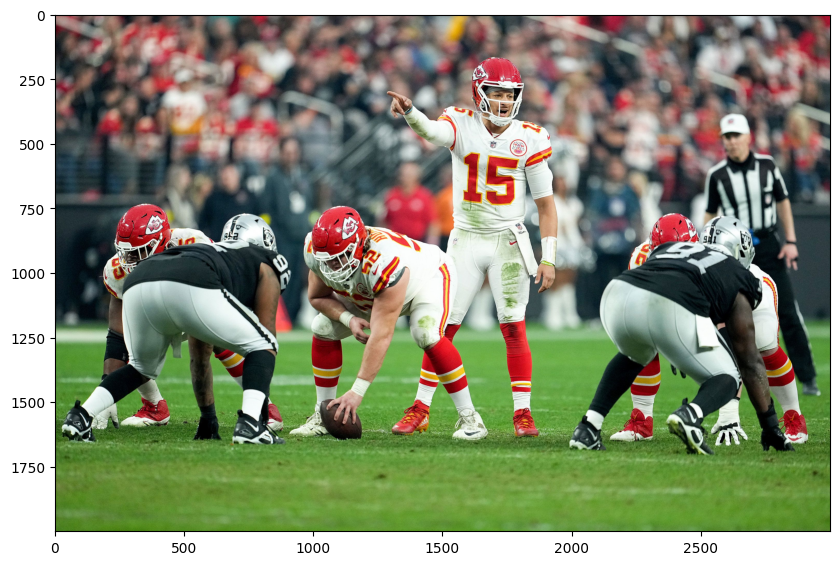

In [77]:
image = cv2.imread('/content/230121121737-01-nfl-playoffs-preview.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [78]:
#creating an ONNX runtime session using the onnxruntime.InferenceSession() func and loads the ONNX model using the sam model
ort_session = onnxruntime.InferenceSession(onnx_model_path)

In [79]:
sam.to(device='cuda')
predictor = SamPredictor(sam)#this creates a SamPredictor object using the sam model
predictor.set_image(image)#set image() method of SamPredictor object is used to set the image
image_embedding = predictor.get_image_embedding().cpu().numpy()# get_image_embedding() method of SamPredictor object is used to get the image embedding , the cpu() method is used to move the tensor to cpu ,and the numpy() method is used to convert the tensor to a nnumpy array
image_embedding.shape

(1, 256, 64, 64)

#selecting a single mask

(1, 1, 2000, 3000)


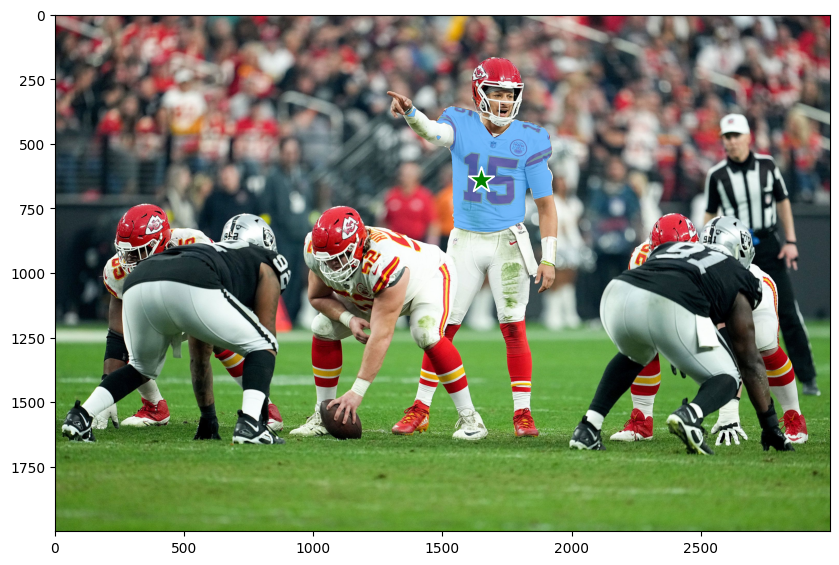

In [85]:
input_point = np.array([[1648,640]]) #var which is a numpy array with shape(1,2) that contains x,y coordinates of a point
input_label = np.array([1])# this var is a numpy array with shape(1,) that contains the label of the point

#Add a batch index, concatenate a padding point, and transform.
#this lines add batch index to the point coordinates and labels , concatenate a padding point with label -1 and transform the point coordinates using the predictor.transform.apply_coord() method
#onnx_coord and onnx_label are created by adding a batch index to the point coordinates and labels , and concatenate a padding point with label -1 .
#the batch index is added by introducing a new axis  using none . this is done because DL model usually process daa in batches so even if there's only one point , it needs to be in the shape of a batch
onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)
#the coordinates are then transformed using predictor.transform.apply_coords methid , this is a normalization or scaling operation to ensure the coordinates are in a suitable range for the model
onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)

#Create an empty mask input and an indicator for no mask.

onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)
#Package the inputs to run in the onnx model

ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

#Predict a mask and threshold it.

masks, _, low_res_logits = ort_session.run(None, ort_inputs)
masks = masks > predictor.model.mask_threshold
print(masks.shape)
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

#selecting multiple mask

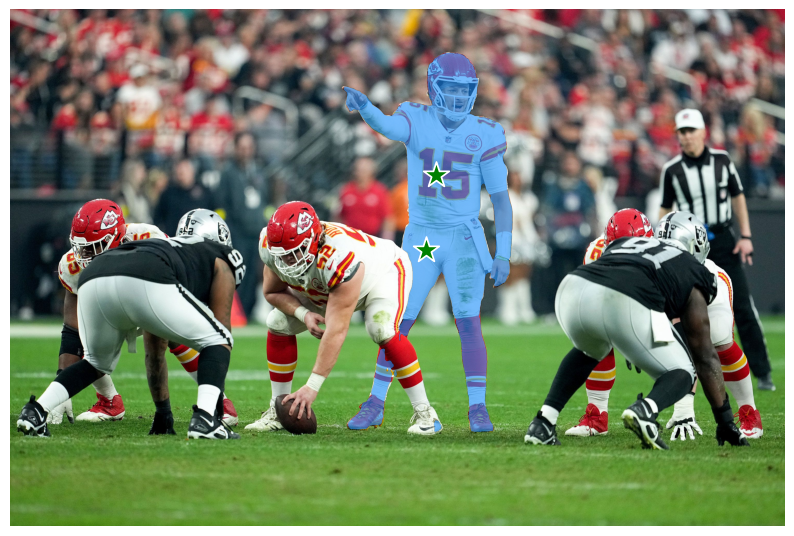

In [86]:
#Example mask input
input_point = np.array([[1648,640],[1609,931]])
input_label = np.array([1,1])

# Use the mask output from the previous run. It is already in the correct form for input to the ONNX model.
onnx_mask_input = low_res_logits
#Transform the points as in the previous example.

onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)
#The has_mask_input indicator is now 1.

onnx_has_mask_input = np.ones(1, dtype=np.float32)
#Package inputs, then predict and threshold the mask.

ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

masks, _, _ = ort_session.run(None, ort_inputs)
masks = masks > predictor.model.mask_threshold
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

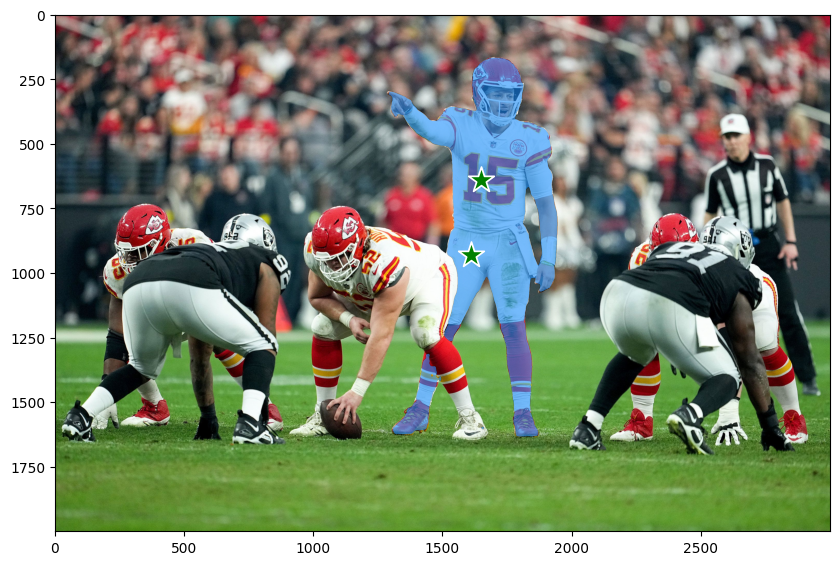

In [90]:
#Specifying a specific object with additional points
input_point = np.array([[1648,640],[1609,931]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)
masks.shape
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

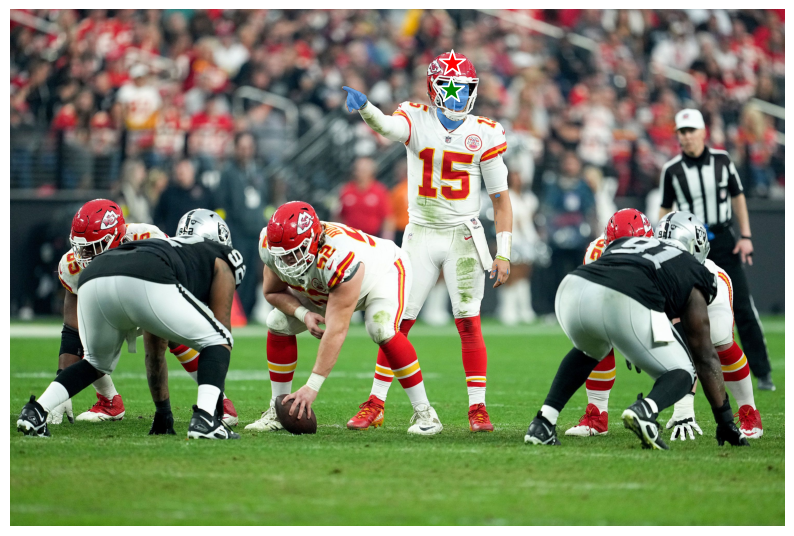

In [91]:
#To exclude the helmet and specify just the face , a background point (with label 0, here shown in red) can be supplied.

input_point = np.array([[1707, 312], [1711, 206]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

#selecting object with box

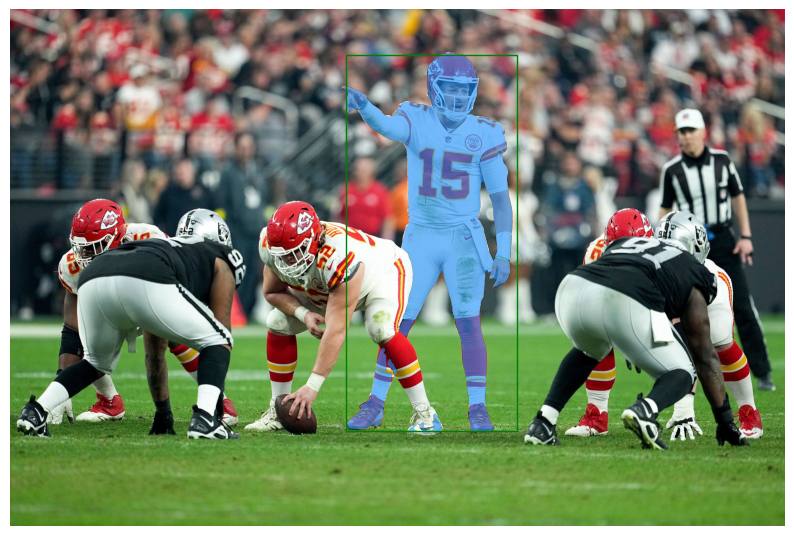

In [92]:
#Specifying a specific object with a box
input_box = np.array([1302,178,1961,1631])
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

#selecting object with box and point

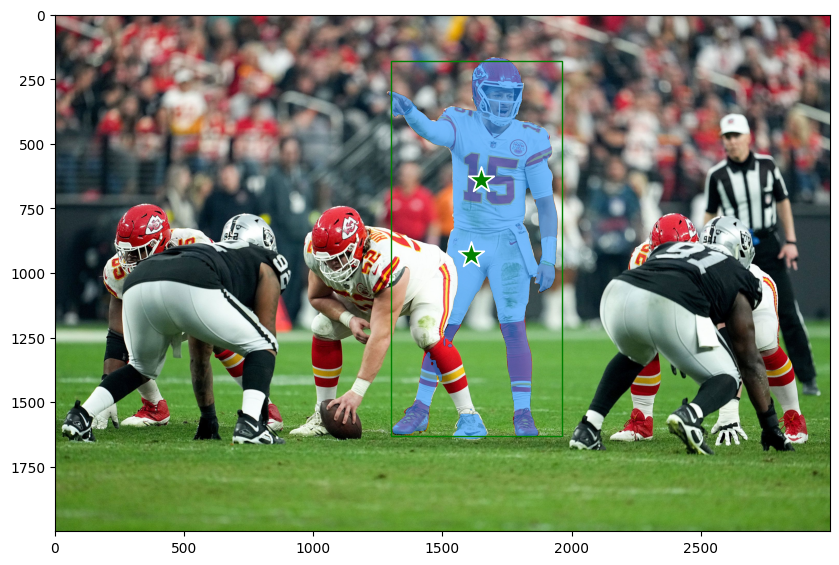

In [96]:
#Combining points and boxes
input_box = np.array([1302,178,1961,1631])
input_point = np.array([[1648,640],[1609,931]])
input_label = np.array([1,1])
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

#selecting multiple objects with box

In [97]:
#Batched prompt inputs
input_boxes = torch.tensor([
    [1334, 171, 1919, 1618],
    [1103,790,1174,854],
    [1992,778,2835,1687,],
    [689,1536,871,1659],
], device=predictor.device)


In [98]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)
masks.shape  # (batch_size) x (num_predicted_masks_per_input) x H x W

torch.Size([4, 1, 2000, 3000])

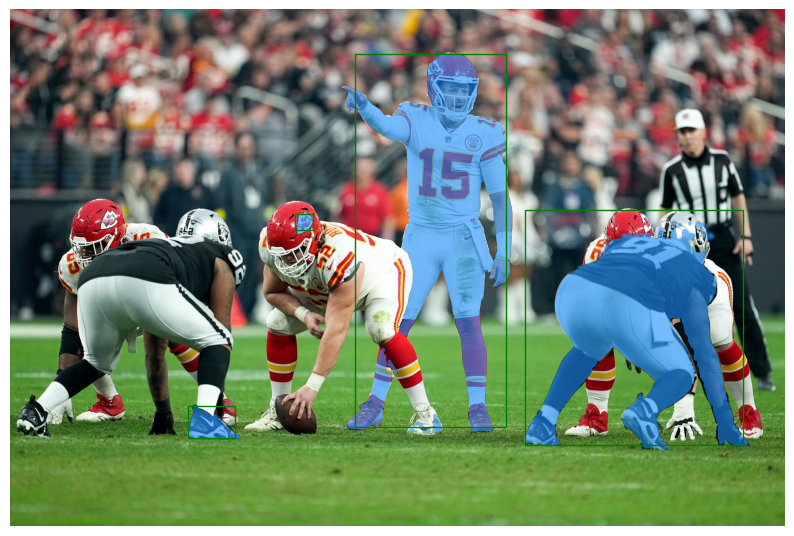

In [99]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca())
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()